## Load library 

In [46]:
import pandas as pd 
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
df = pd.read_csv("/content/drive/MyDrive/vef final test/data.csv", encoding= 'iso-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data cleaning 

### Data format cleaning

In [116]:
df.shape

(541909, 8)

In [3]:
#renam colums
df.rename(columns={"InvoiceNo":"invoice_num", 
                   "StockCode":"stock_code", 
                  "Description":"description", 
                  "Quantity":"quantity", 
                  "InvoiceDate":"invoice_date", 
                  "UnitPrice":"unit_price", 
                  "CustomerID":"customer_id", 
                  "Country":"country"}, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_num   541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
#change type of invoice-date to date-time
df['invoice_date']=pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')

In [6]:
#convert description colum to lowercase
df['description']=df.description.str.lower()

In [7]:
df.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Missing data analysis and handling

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_num   541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
#check null value
df.isnull().sum().sort_values(ascending=False)

customer_id     135080
description       1454
country              0
unit_price           0
invoice_date         0
quantity             0
stock_code           0
invoice_num          0
dtype: int64

In [10]:
#check detail null values
df_miss=df[df.isnull().any(axis=1)]
df_miss.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,decorative rose bathroom bottle,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,decorative cats bathroom bottle,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,polkadot rain hat,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,rain poncho retrospot,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [11]:
#drop null value and defirn a new df called 'df_new'
df_new=df.dropna()

In [12]:
#check if there a are missing values in the new dataframe
df_new.isnull().sum().sort_values(ascending=False)

country         0
customer_id     0
unit_price      0
invoice_date    0
quantity        0
description     0
stock_code      0
invoice_num     0
dtype: int64

### Duplicate value

In [13]:
df_new.duplicated().sum()

5225

In [14]:
df_new[df_new.duplicated()].head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
517,536409,21866,union jack flag luggage tag,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,hand warmer scotty dog design,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,set 2 tea towels i love london,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,scottie dog hot water bottle,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,round snack boxes set of 4 skulls,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In [15]:
#drop duplicate 
df_new.drop_duplicates(inplace=True)

In [16]:
df_new.duplicated().sum()

0

### Change collum type

In [17]:
#convert customer_id from float to int
df_new['customer_id']=df_new.customer_id.astype('int64')

In [18]:
df_new.describe()

,quantity,unit_price,customer_id
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Quantity has negative values and unit price has a minimum value of 0

In [19]:
#caculate order has quantity <0
np.sum(df_new['quantity'] < 0)

8872

There are 8872 transactions with negative quantity. We will investigate if they are related to canceled orders or mistakes.

### Cancel orders analysis

In [20]:
# cancel orders has invoice_num start with 'C'
canceled_orders = df_new[df_new['invoice_num'].apply(lambda x: x[0]=='C')]
canceled_orders.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,set of 3 coloured flying ducks,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,plasters in tin circus parade,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,pack of 12 pink paisley tissues,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,pack of 12 blue paisley tissues,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [21]:
(canceled_orders['quantity'] < 0).sum()

8872

Yes, all the transactions with negative values are canceled orders so we just focus on orders with quantity >0

In [22]:
df_new = df_new[df_new['quantity'] > 0]

In [23]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_num   392732 non-null  object        
 1   stock_code    392732 non-null  object        
 2   description   392732 non-null  object        
 3   quantity      392732 non-null  int64         
 4   invoice_date  392732 non-null  datetime64[ns]
 5   unit_price    392732 non-null  float64       
 6   customer_id   392732 non-null  int64         
 7   country       392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


In [24]:
df_new.describe()

,quantity,unit_price,customer_id
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


### Feature engineering 

In [25]:
# add a column 'amount_spent'
df_new['amount_spent']=df_new['quantity'] * df_new['unit_price']

In [26]:
df_new.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,amount_spent
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [27]:
#reorder columns for easier reference
df_new=df_new[['invoice_num', 'invoice_date', 'stock_code', 'description', 'quantity', 'unit_price', 'amount_spent', 'customer_id', 'country']]

In [28]:
df_new.head()

,invoice_num,invoice_date,stock_code,description,quantity,unit_price,amount_spent,customer_id,country
0,536365,2010-12-01 08:26:00,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


In [29]:
#create columns for day, month, year
df_new.insert(loc=2, column='year_month', value=df_new['invoice_date'].map(lambda x: 100 * x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.invoice_date.dt.month)
df_new.insert(loc=4, column='day', value=(df_new.invoice_date.dt.dayofweek) + 
              1) # +1 is used to make Monday=1.....until Sunday=7
df_new.insert(loc=5, column='hour', value=df_new.invoice_date.dt.hour)

In [30]:
df_new.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,customer_id,country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


## EDA

### How many orders made by the customers?

In [31]:
df_new.groupby(by=['customer_id','country'], as_index=False)['invoice_num'].count().head()

,customer_id,country,invoice_num
0,12346,United Kingdom,1
1,12347,Iceland,182
2,12348,Finland,31
3,12349,Italy,73
4,12350,Norway,17


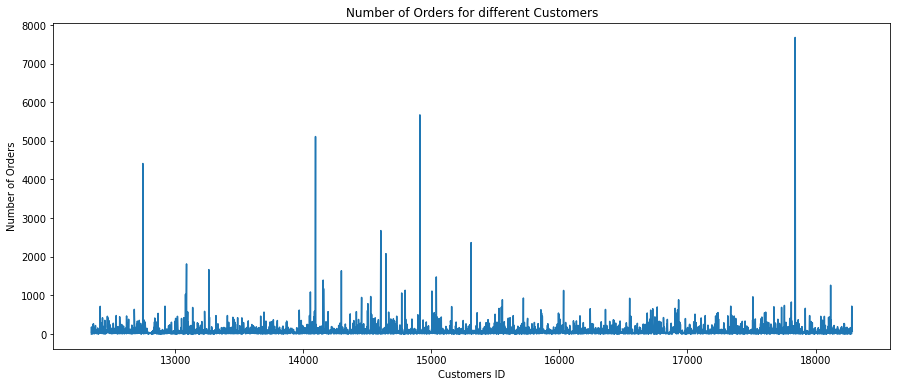

In [32]:
# plot the number of order by customer_id
orders = df_new.groupby(by=['customer_id','country'], as_index=False)['invoice_num'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.customer_id, orders.invoice_num)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

In [33]:
# TOP 5 most number of orders
print('The TOP 5 customers with most number of orders')
orders.sort_values(by='invoice_num', ascending=False).head()

The TOP 5 customers with most number of orders


,customer_id,country,invoice_num
4019,17841,United Kingdom,7676
1888,14911,EIRE,5672
1298,14096,United Kingdom,5111
334,12748,United Kingdom,4413
1670,14606,United Kingdom,2677


### How much money spent by the customers?¶

In [34]:
money_spent = df_new.groupby(by=['customer_id','country'], as_index=False)['amount_spent'].sum()
money_spent.head()

,customer_id,country,amount_spent
0,12346,United Kingdom,77183.60
1,12347,Iceland,4310.00
2,12348,Finland,1797.24
3,12349,Italy,1757.55
4,12350,Norway,334.40


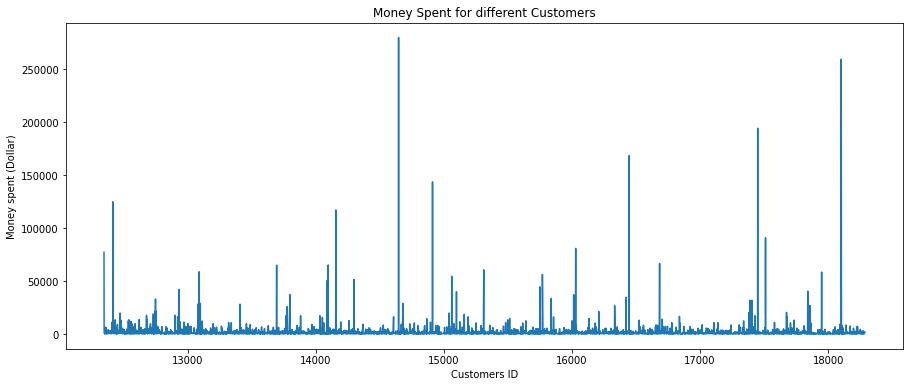

In [35]:
#Plot money spent per customer
money_spent = df_new.groupby(by=['customer_id','country'], as_index=False)['amount_spent'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.customer_id, money_spent.amount_spent)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

In [36]:
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='amount_spent', ascending=False).head()

The TOP 5 customers with highest money spent...


,customer_id,country,amount_spent
1698,14646,Netherlands,280206.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194390.79
3017,16446,United Kingdom,168472.50
1888,14911,EIRE,143711.17


### Discover Number of order

In [47]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

#### How many orders (per month)?

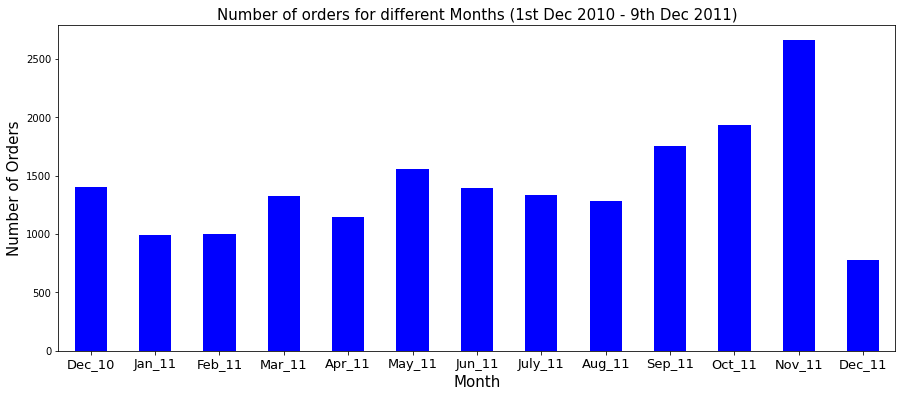

In [50]:
ax = df_new.groupby('invoice_num')['year_month'].unique().value_counts().sort_index().plot(kind='bar',color='blue',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

Nov-11 has highest number of orders

#### How many orders per day?

In [43]:
df_new.groupby('invoice_num')['day'].unique().value_counts().sort_index()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[1]    2863
[2]    3185
[3]    3455
[4]    4033
[5]    2831
[7]    2169
Name: day, dtype: int64

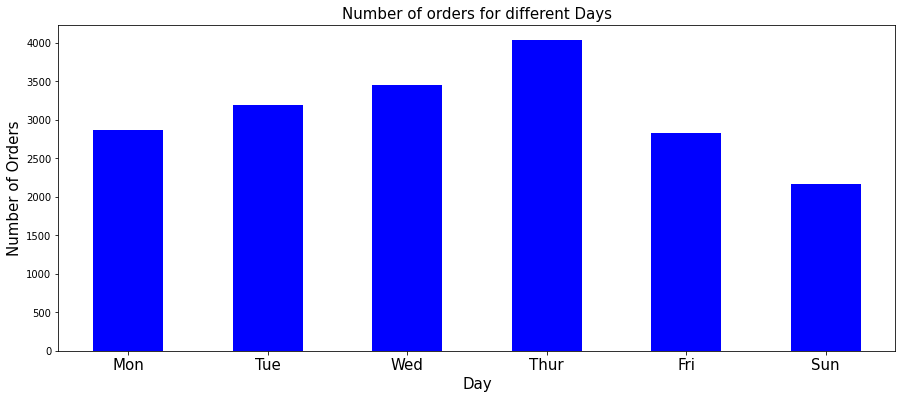

In [51]:
ax = df_new.groupby('invoice_num')['day'].unique().value_counts().sort_index().plot(kind='bar',color='blue',figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

Thursday has highest number of orders but the data don't have any order on Saturday

#### How many orders per hour?

In [52]:
df_new.groupby('invoice_num')['hour'].unique().value_counts().iloc[:-1].sort_index()

TypeError: ignored

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[6]        1
[7]       29
[8]      555
[9]     1394
[10]    2226
[11]    2276
[12]    3129
[13]    2637
[14]    2275
[15]    2038
[16]    1100
[17]     544
[18]     169
[19]     144
[20]      18
Name: hour, dtype: int64

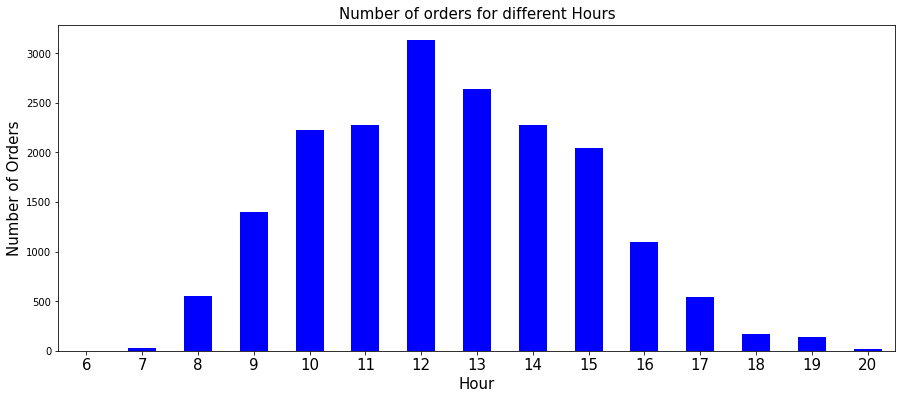

In [54]:
ax = df_new.groupby('invoice_num')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',color='blue',figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

User usually make orders in the noon, highest at 12p.m

### Discover patterns for Unit Price

In [55]:
df_new.unit_price.describe()

count    392732.000000
mean          3.125596
std          22.240725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: unit_price, dtype: float64

There are orders with 0 unit price (free items)

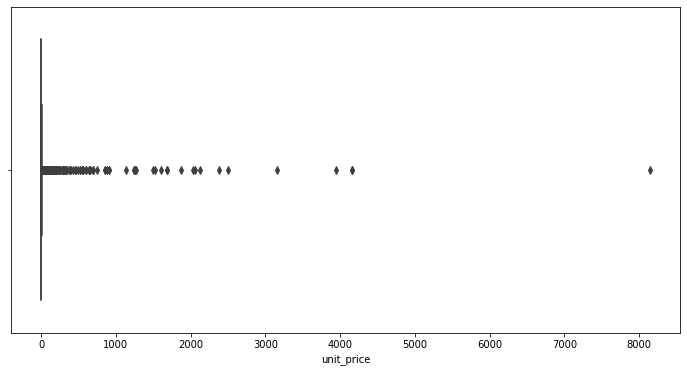

In [56]:
plt.subplots(figsize=(12,6))
sns.boxplot(df_new.unit_price)
plt.show()

It looks like the majority of products have unit_price lower than 10. We will use 10 as a threshold value to deeper explore the unit_price.

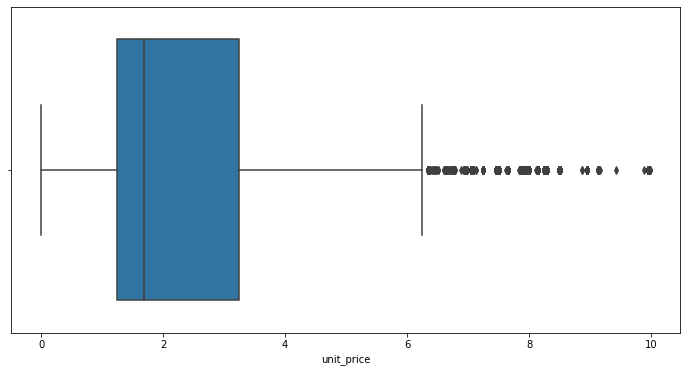

In [57]:
plt.subplots(figsize=(12,6))
sns.boxplot(df_new[df_new['unit_price'] < 10].unit_price)
plt.show()

unit price usually about $1- $3

In [58]:
# deep-dive to free item
df_free=df_new[df_new['unit_price'] == 0]
df_free.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,customer_id,country
9302,537197,2010-12-05 14:02:00,201012,12,7,14,22841,round cake tin vintage green,1,0.0,0.0,12647,Germany
33576,539263,2010-12-16 14:36:00,201012,12,4,14,22580,advent calendar gingham sack,4,0.0,0.0,16560,United Kingdom
40089,539722,2010-12-21 13:45:00,201012,12,2,13,22423,regency cakestand 3 tier,10,0.0,0.0,14911,EIRE
47068,540372,2011-01-06 16:41:00,201101,1,4,16,22090,paper bunting retrospot,24,0.0,0.0,13081,United Kingdom
47070,540372,2011-01-06 16:41:00,201101,1,4,16,22553,plasters in tin skulls,24,0.0,0.0,13081,United Kingdom


In [59]:
df_free.year_month.value_counts().sort_index(ascending=False)

201111    14
201110     3
201109     2
201108     6
201107     2
201105     2
201104     2
201103     2
201102     1
201101     3
201012     3
Name: year_month, dtype: int64

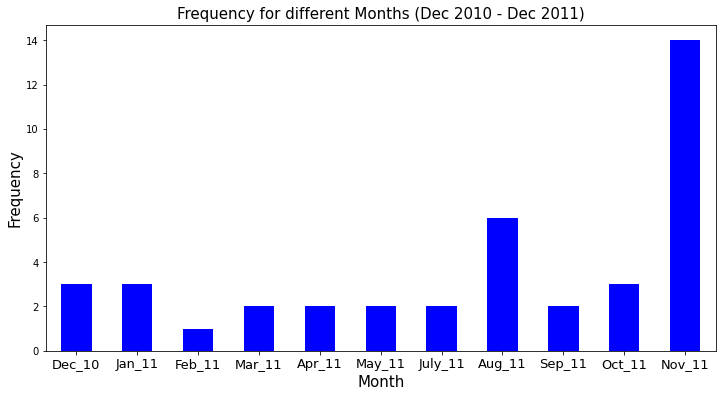

In [61]:
ax = df_free.year_month.value_counts().sort_index().plot(kind='bar',figsize=(12,6), color='blue')
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()

On average, we see that the companies give 2 items for free each month. No free items were given on June 2011 and Sept 2011. Nov-11 has highest free items

### Discover patterns for each Country

#### How many orders for each country?

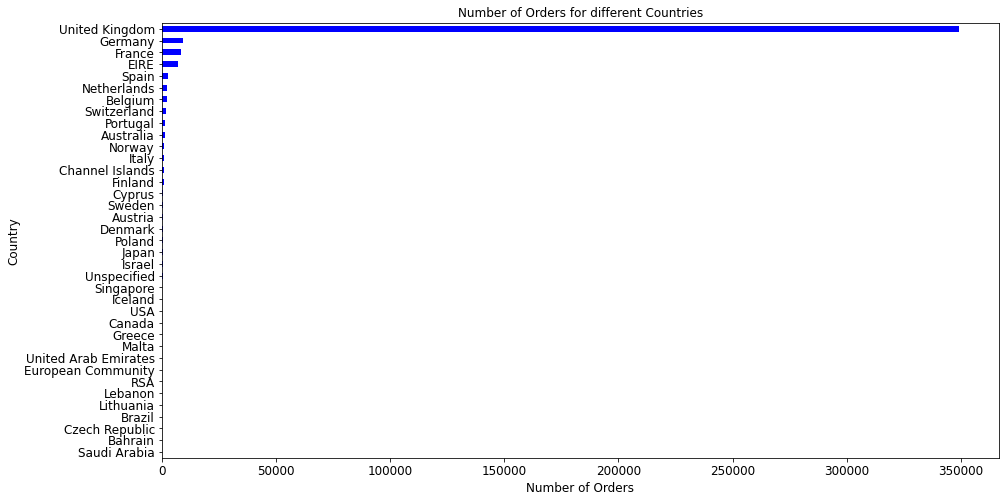

In [63]:
group_country_orders = df_new.groupby('country')['invoice_num'].count().sort_values()

# plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12, color='blue')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

The company is based in UK, so it seems natural that the country with most sold items is UK.
For further analysis, UK will be dropped

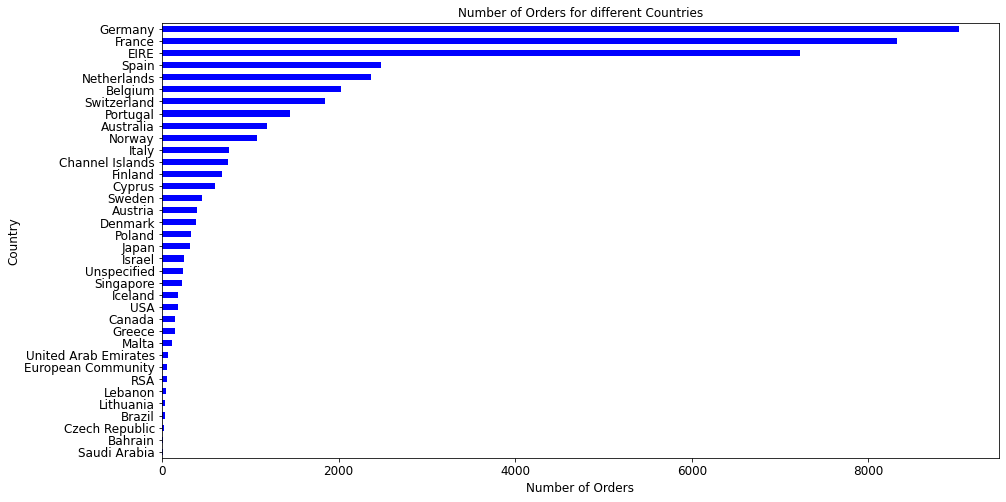

In [65]:
group_country_orders = df_new.groupby('country')['invoice_num'].count().sort_values()
del group_country_orders['United Kingdom']

# plot number of unique customers in each country (without UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12, color='blue')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

#### How much money spent by each country?



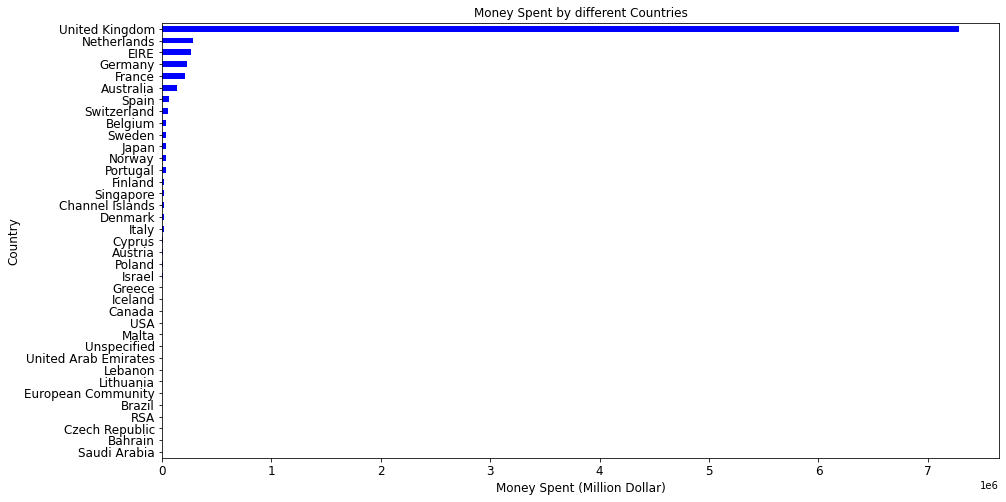

In [67]:
group_country_amount_spent = df_new.groupby('country')['amount_spent'].sum().sort_values()

# plot total money spent by each country (with UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot(kind='barh', fontsize=12, color='blue')
plt.xlabel('Money Spent (Million Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

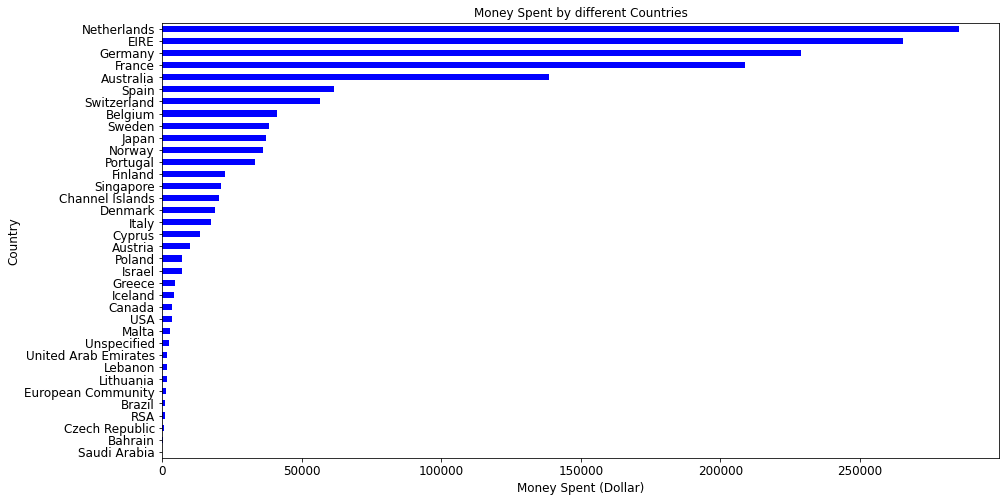

In [68]:
group_country_amount_spent = df_new.groupby('country')['amount_spent'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot(kind='barh', fontsize=12, color='blue')
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

### Discover Sold product 

In [69]:
df_new['stock_code'].nunique()

3665

There are 3665 different sold products in the dataset

#### Which products are the most sold?

In [70]:
most_sold_products=df_new.groupby(by=['stock_code','description'])['quantity'].sum().sort_values(ascending=False).iloc[:50]
df_top_prod=most_sold_products.to_frame().reset_index()
df_top_prod.head(10)

,stock_code,description,quantity
0,23843,"paper craft , little birdie",80995
1,23166,medium ceramic top storage jar,77916
2,84077,world war 2 gliders asstd designs,54319
3,85099B,jumbo bag red retrospot,46078
4,85123A,white hanging heart t-light holder,36706
5,84879,assorted colour bird ornament,35263
6,21212,pack of 72 retrospot cake cases,33670
7,22197,popcorn holder,30919
8,23084,rabbit night light,27153
9,22492,mini paint set vintage,26076


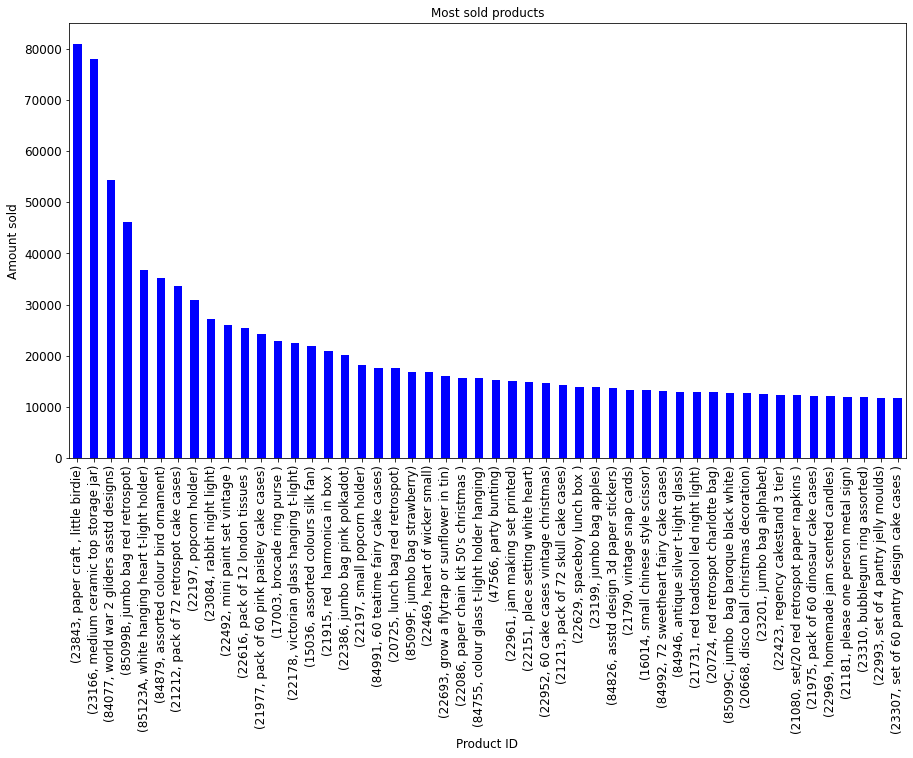

In [72]:
plt.subplots(figsize=(15,8))
most_sold_products.plot(kind='bar', fontsize=12, color='blue')
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Amount sold', fontsize=12)
plt.title('Most sold products', fontsize=12)
plt.show()

Results obtained from Exploratory Data Analysis (EDA)
- The customer with the highest number of orders comes from the United Kingdom (UK)
- The customer with the highest money spent on purchases comes from Netherlands
- The company receives the highest number of orders from customers in the UK (since it is a UK-based company). 
- Therefore, the TOP 5 countries (including UK) that place the highest number of orders are as below:
-- United Kingdom
-- Germany
-- France
-- Ireland (EIRE)
-- Spain
- As the company receives the highest number of orders from customers in the UK (since it is a UK-based company), customers in the UK spend the most on their purchases. Therefore, the TOP 5 countries (including UK) that spend the most money on purchases are as below:
-- United Kingdom
-- Netherlands
-- Ireland (EIRE)
-- Germany
-- France
- November 2011 has the highest sales
- The month with the lowest sales is undetermined as the dataset consists of transactions until 9th December 2011 in December
- There are no transactions on Saturday between 1st Dec 2010 - 9th Dec 2011
- The number of orders received by the company tends to increases from Monday to Thursday and decrese afterward
- The company receives the highest number of orders at 12:00pm
- Possibly most customers made purchases during lunch hour between 12:00pm - 2:00pm
- The company tends to give out FREE items for purchases occasionally each month (Except June 2011)
However, it is not clear what factors contribute to giving out the FREE items to the particular customers

## Segmentation

## Create RFM Score

In [73]:
df_new.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,customer_id,country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


### Recency

In [74]:
# First, detect the most recent day in the datasets
print("Min Date", df_new["invoice_date"].min(), "\nMax Date", df_new["invoice_date"].max())

Min Date 2010-12-01 08:26:00 
Max Date 2011-12-09 12:50:00


In [75]:
r_series = (df_new["invoice_date"].max() - df_new.groupby("customer_id").agg({"invoice_date":"max"})).rename(columns = {"invoice_date":"recency"})
r_series['recency'] = r_series['recency'].apply(lambda x: x.days) # Use apply to map the function (lambda) to all elements of the series
r_series.head()

,recency
customer_id,
12346,325
12347,1
12348,74
12349,18
12350,309


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effd146db50>]],
      dtype=object)

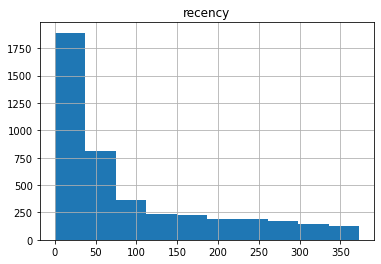

In [76]:
r_series.hist()

### Frequency

In [ ]:
## Count how many days, a customer have orders 
f_series = df_new.groupby("customer_id").agg({"invoice_date":"nunique"}).rename(columns={"invoice_date": "frequency"})
f_series.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effd1cc5750>]],
      dtype=object)

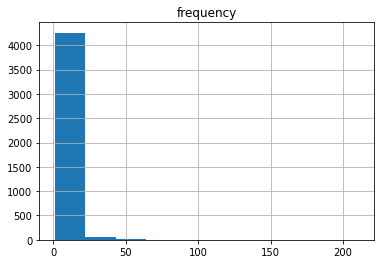

In [78]:
f_series.hist()

In [79]:
cut_95 = f_series.frequency.quantile(0.95)
outliers = f_series[f_series.frequency > cut_95].shape
print('Above p95 of {}: {} obs.'.format(cut_95, outliers))

Above p95 of 13.0: (207, 1) obs.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effd1a0a510>]],
      dtype=object)

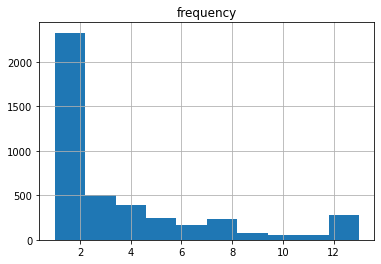

In [80]:
f_series[f_series.frequency > cut_95] = cut_95 ## Replace the one > p95, by 95 value
f_series.hist()

### Monetory

In [81]:
## sum the value of orders 
m_series = df_new.groupby("customer_id").agg({"amount_spent":"sum"}).rename(columns={"amount_spent":"monetary"})
m_series.head()

,monetary
customer_id,
12346,77183.60
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effd198c650>]],
      dtype=object)

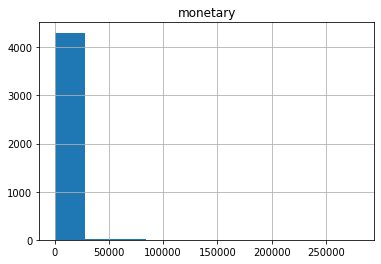

In [82]:
m_series.hist()

In [83]:
cut_95 = m_series.monetary.quantile(0.95)
outliers = m_series[m_series.monetary > cut_95].shape
print('Above p95 of {}: {} obs.'.format(cut_95, outliers))

Above p95 of 5787.242999999971: (217, 1) obs.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effd17745d0>]],
      dtype=object)

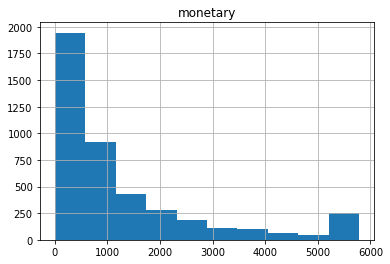

In [84]:
m_series[m_series.monetary > cut_95] = cut_95 ## Replace the one > p95, by 95 value
m_series.hist()

### RFM score

In [85]:
rfm = pd.concat([r_series, f_series, m_series], axis=1)
rfm.head()

,recency,frequency,monetary
customer_id,,,
12346,325,1.0,5787.243
12347,1,7.0,4310.000
12348,74,4.0,1797.240
12349,18,1.0,1757.550
12350,309,1.0,334.400


In [86]:
rfm['recency_score'] = pd.qcut(rfm['recency'],5,labels=[5,4,3,2,1])

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"),5,labels=[1,2,3,4,5])

rfm['monetary_score'] = pd.qcut(rfm['monetary'],5,labels=[1,2,3,4,5])

rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str)+ rfm['frequency_score'].astype(str))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
customer_id,,,,,,,
12346,325,1.0,5787.243,1,1,5,11
12347,1,7.0,4310.000,5,5,5,55
12348,74,4.0,1797.240,2,4,4,24
12349,18,1.0,1757.550,4,1,4,41
12350,309,1.0,334.400,1,1,2,11


## Segmentation

In [87]:
## With all 3 elements, there are many segments to focus. Let's segment by R, F only (keep M for comparison)
seg_map = {
    r'[1-2][1-2]': 'Hibernating', ## Recency =< 2, Bad Frequency =< 2
    r'[1-2][3-4]': 'At Risk', ## Bad Recency =< 2, Mid Frequency from 3-4
    r'[1-2]5': 'Can\'t Loose', 
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) 
## Notice that, here we only consider R, F => M is the value to summary
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment
customer_id,,,,,,,,
12346,325,1.0,5787.243,1,1,5,11,Hibernating
12347,1,7.0,4310.000,5,5,5,55,Champions
12348,74,4.0,1797.240,2,4,4,24,At Risk
12349,18,1.0,1757.550,4,1,4,41,Promising
12350,309,1.0,334.400,1,1,2,11,Hibernating


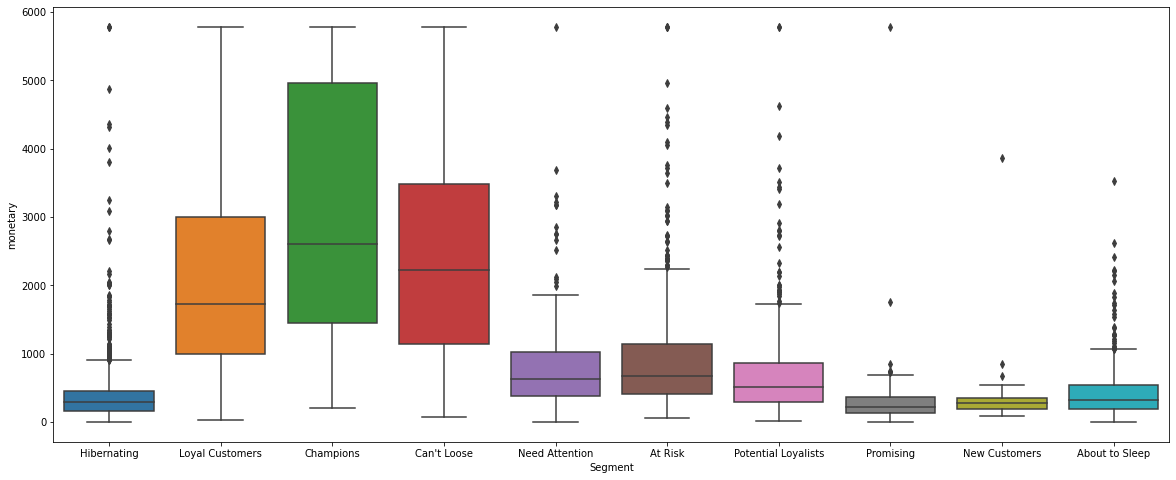

In [88]:
plt.figure(figsize=(20, 8))
sns.boxplot(x='Segment', y='monetary', data=rfm.sort_values(by='monetary',ascending=False))

## Segment Analysis

In [89]:
rfm[['recency','monetary','frequency','Segment']].groupby('Segment').agg({'mean','std','max','min'})

recency           ... frequency                
                           mean min  max  ...       min   max       std
Segment                                   ...                          
About to Sleep        52.553977  33   71  ...       1.0   2.0  0.368913
At Risk              154.318417  72  372  ...       2.0   5.0  0.930855
Can't Loose          130.500000  72  371  ...       6.0  13.0  2.358495
Champions              4.881329   0   12  ...       3.0  13.0  3.614295
Hibernating          216.952963  72  373  ...       1.0   2.0  0.299764
Loyal Customers       32.544686  13   71  ...       3.0  13.0  2.904863
Need Attention        51.928962  33   71  ...       2.0   3.0  0.468679
New Customers          5.857143   0   11  ...       1.0   1.0  0.000000
Potential Loyalists   16.095142   0   32  ...       1.0   3.0  0.652546
Promising             22.350000  13   32  ...       1.0   1.0  0.000000

[10 rows x 12 columns]

In [90]:
rfm.Segment.value_counts()

Hibernating            1063
Loyal Customers         828
Champions               632
At Risk                 581
Potential Loyalists     494
About to Sleep          352
Need Attention          183
Promising               100
Can't Loose              64
New Customers            42
Name: Segment, dtype: int64

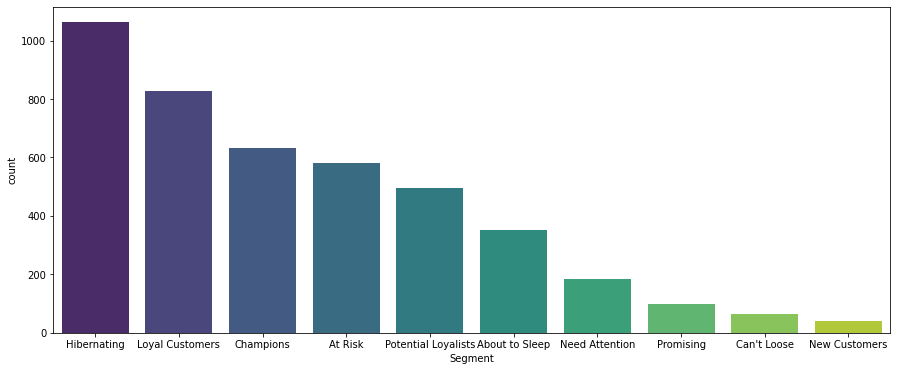

In [91]:
#number of customer per segment 
plt.figure(figsize=(15,6))
sns.countplot(rfm['Segment'], order=rfm['Segment'].value_counts().index, palette='viridis')
plt.show()

In [92]:
!pip install squarify

In [93]:
import squarify

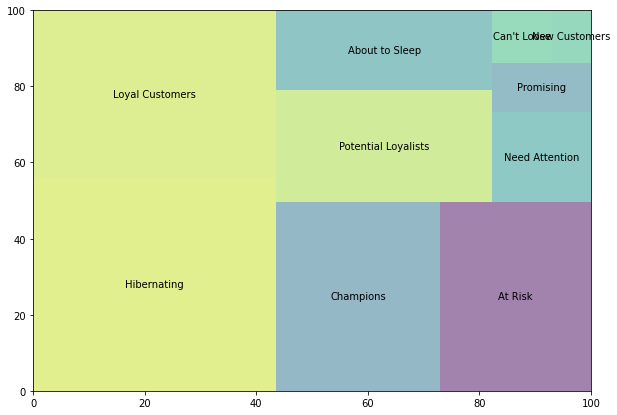

In [94]:
df_plot = rfm.Segment.value_counts()
plt.figure(figsize=(10, 7))
squarify.plot(df_plot, label=df_plot.index, alpha=0.5)
plt.show()

## Deep dive to 3 main segment

In [95]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,Segment
customer_id,,,,,,,,
12346,325,1.0,5787.243,1,1,5,11,Hibernating
12347,1,7.0,4310.000,5,5,5,55,Champions
12348,74,4.0,1797.240,2,4,4,24,At Risk
12349,18,1.0,1757.550,4,1,4,41,Promising
12350,309,1.0,334.400,1,1,2,11,Hibernating


In [96]:
df_new.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,customer_id,country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom


In [97]:
# merge segmentation into data 
merged_df_new = pd.merge(df_new, rfm['Segment'].reset_index())
merged_df_new.head()

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,customer_id,country,Segment
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom,Can't Loose
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom,Can't Loose
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom,Can't Loose
3,536365,2010-12-01 08:26:00,201012,12,3,8,84029G,knitted union flag hot water bottle,6,3.39,20.34,17850,United Kingdom,Can't Loose
4,536365,2010-12-01 08:26:00,201012,12,3,8,84029E,red woolly hottie white heart.,6,3.39,20.34,17850,United Kingdom,Can't Loose


### Loyal Customers

In [98]:
# Loyal Customers: Top10 products 
(merged_df_new[merged_df_new.Segment == 'Loyal Customers']
.groupby('description')
.agg({'invoice_num': 'count','unit_price': 'mean','quantity':'mean'})
.sort_values('invoice_num', ascending=False)
.rename(columns={'invoice_num':'num_order','quantity':'quantity_per_order'})).head(10)

,num_order,unit_price,quantity_per_order
description,,,
white hanging heart t-light holder,627,2.895136,12.663477
regency cakestand 3 tier,506,12.465415,5.913043
jumbo bag red retrospot,487,2.017084,25.909651
assorted colour bird ornament,483,1.682547,31.434783
lunch bag red retrospot,437,1.644508,12.711670
party bunting,423,4.868085,11.092199
postage,387,45.844057,2.922481
lunch bag black skull.,372,1.648387,9.266129
set of 3 cake tins pantry design,357,4.926471,4.974790


In [99]:
# Loyal Customers: Top10 customer 
(merged_df_new[merged_df_new.Segment == 'Loyal Customers']
.groupby('customer_id')
.agg({'invoice_num': 'count','unit_price': 'mean','quantity':'mean','amount_spent':'sum'})
.sort_values(['amount_spent','invoice_num'], ascending=False)
.rename(columns={'invoice_num':'num_order','quantity':'quantity_per_order'})).head(10)

,num_order,unit_price,quantity_per_order,amount_spent
customer_id,,,,
12415,716,2.928883,108.477654,124914.53
16029,241,36.185270,166.423237,80850.84
12931,82,1.701707,341.512195,42055.96
16422,369,1.813930,91.338753,34684.40
14680,258,2.415698,52.232558,28754.11
12753,197,2.337360,57.974619,21429.39
12744,222,58.333288,23.608108,21279.29
12731,274,3.346168,30.791971,18895.91
12678,165,6.554667,66.200000,17628.46


### Champions

In [100]:
# Champions: Top10 products
(merged_df_new[merged_df_new.Segment == 'Champions']
.groupby('description')
.agg({'invoice_num': 'count','unit_price': 'mean','quantity':'mean'})
.sort_values('invoice_num', ascending=False)
.rename(columns={'invoice_num':'num_order','quantity':'quantity_per_order'})).head(10)

,num_order,unit_price,quantity_per_order
description,,,
jumbo bag red retrospot,818,2.015220,32.096577
white hanging heart t-light holder,795,2.884050,23.620126
regency cakestand 3 tier,669,12.426457,10.955157
lunch bag red retrospot,650,1.674000,14.295385
party bunting,545,4.869670,11.864220
lunch bag black skull.,534,1.639139,11.367041
assorted colour bird ornament,486,1.673704,27.292181
set of 3 cake tins pantry design,448,4.998415,8.263393
jumbo bag pink polkadot,448,2.011875,27.156250


In [101]:
# Champions: Top10 customer 
(merged_df_new[merged_df_new.Segment == 'Champions']
.groupby('customer_id')
.agg({'invoice_num': 'count','unit_price': 'mean','quantity':'mean','amount_spent':'sum'})
.sort_values(['amount_spent','invoice_num'], ascending=False)
.rename(columns={'invoice_num':'num_order','quantity':'quantity_per_order'})).head(10)

,num_order,unit_price,quantity_per_order,amount_spent
customer_id,,,,
14646,2080,2.488505,94.947596,280206.02
18102,431,4.503295,148.779582,259657.30
17450,336,3.378929,208.252976,194390.79
14911,5672,4.610428,14.190762,143711.17
14156,1395,3.834215,41.410753,117210.08
17511,963,2.306625,67.029076,91062.38
16684,277,2.451625,181.425993,66653.56
14096,5111,6.521708,3.199374,65164.79
13694,568,1.568996,111.464789,65039.62


### Hibernating

In [102]:
# Hibernating: Top10 products
(merged_df_new[merged_df_new.Segment == 'Hibernating']
.groupby('description')
.agg({'invoice_num': 'count','unit_price': 'mean','quantity':'mean'})
.sort_values('invoice_num', ascending=False)
.rename(columns={'invoice_num':'num_order','quantity':'quantity_per_order'})).head(10)

,num_order,unit_price,quantity_per_order
description,,,
white hanging heart t-light holder,130,2.910000,10.753846
regency cakestand 3 tier,126,12.550000,3.984127
postage,102,29.710784,2.627451
party bunting,101,4.885644,7.831683
assorted colour bird ornament,93,1.690000,12.225806
set of 3 cake tins pantry design,89,4.910674,5.146067
baking set 9 piece retrospot,89,4.942135,4.078652
jam making set with jars,82,4.158537,7.658537
pack of 72 retrospot cake cases,73,0.541096,31.821918


In [103]:
# Hibernating: Top10 customer 
(merged_df_new[merged_df_new.Segment == 'Hibernating']
.groupby('customer_id')
.agg({'invoice_num': 'count','unit_price': 'mean','quantity':'mean','amount_spent':'sum'})
.sort_values(['amount_spent','invoice_num'], ascending=False)
.rename(columns={'invoice_num':'num_order','quantity':'quantity_per_order'})).head(10)

,num_order,unit_price,quantity_per_order,amount_spent
customer_id,,,,
12346,1,1.040000,74215.000000,77183.600
12590,68,10.547353,62.985294,9864.260
12435,36,5.479167,57.083333,7829.890
12688,171,4.124737,17.707602,4873.810
12752,53,2.294151,42.679245,4366.780
18251,16,0.771875,489.000000,4314.720
12378,219,2.997443,11.547945,4008.620
12755,4,5.025000,372.750000,3811.950
13952,137,3.983292,10.445255,3251.071
